In [1]:
##### External Packages
import numpy as np
from os import system as s
import sys
import deepdish as dd
##### Internal Packages

##### Import Plot Packages

%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


In [2]:
#It add (Mult = 1) or remove (Mult = -1) the position of the central to the satellites
def AddToSat(Arr,Type,Mult = 1):
    last = Arr[0]
    for i in range(len(Arr)):
        if Type[i]: Arr[i] += Mult*last
        else:   last = Arr[i]
            
#Correct for periodic boundaries
def Correct(Arr,LBox,Type,Cond1 = True):
    LBox2 = LBox/2.
    SatID = Type > 0
    for i in range(3):
        if Cond1:
            NCond1 = np.where((Arr[:,i] > LBox2) & SatID)
            Arr[:,i][NCond1] = Arr[:,i][NCond1]-LBox
            NCond2 = np.where((Arr[:,i] < -LBox2) & SatID)
            Arr[:,i][NCond2] = LBox+Arr[:,i][NCond2]
        else:
            NCond1 = np.where((Arr[:,i] >= LBox) & SatID)
            Arr[:,i][NCond1] = Arr[:,i][NCond1]-LBox
            NCond2 = np.where((Arr[:,i] < 0) & SatID)
            Arr[:,i][NCond2] = LBox+Arr[:,i][NCond2]
#It assigne the central position to all it satellites (all satellies are now at the center of it halo)
def GiveToSat(Arr,Type):
    last = Arr[0]
    for i in range(len(Arr)):
        if Type[i]: Arr[i] = last
        else:   last = Arr[i]


In [3]:
#For the MS & MS-WMAP7
LBox = 500.
NBin,Xmin,Xmax = 70.,9.,16.

In [5]:
#I can send this file if needed, its 1.5 Gb
d = dd.io.load('Gup2011_sn63.hdf5')

In [6]:
#It sort the position of the objects first by fofID and then by type
#This is the main 'trick' of this algorithm that make the shufflig code
#Really fast, the Data will have the following structure:
#haloID Type
#0 0
#0 1
#0 1
#0 2
#1 0
#2 0
#2 1
#3 0
#4 0
#4 2
ind = np.lexsort((d['Type'],d['fofID']))

Pos      = np.copy(d['pos'][ind])
HaloMass = np.copy(d['M200c'][ind])
Type     = np.copy(d['Type'][ind])
HaloInd  = np.copy(d['fofID'][ind])
MStell   = np.copy(d['Mstell'][ind])

In [7]:
%%time
# I bin for halo mass
iMass    = ((np.copy(HaloMass)-Xmin)/(Xmax-Xmin)*NBin).astype(int)
# Central Mask
CentralID = Type==0
# I remove the position of the central to the satellite
# ie. the position of the satellite is now relative to it halo
AddToSat(Pos,Type,-1)
# Correct for periodic bounds
Correct(Pos,LBox,Type,Cond1 = True)
# I go, halo bin per halo bin, shuffling the satellites
for i in range(int(NBin)):
    # Select all central galaxies in the halo mass bin
    IDs = np.where((CentralID) & (i == iMass))[0]
    # Copy the IDs, maybe a copy.copy or even better, copy.deepcopy would work too
    IDs_Shuffle = np.copy(IDs)
    # Shuffle the index of the central galaxies
    np.random.shuffle(IDs_Shuffle)
    # Relocate the central galaxies to it new halo
    Pos[IDs] = Pos[IDs_Shuffle]
    # Re-assign the halo mass to it new halo. Since the halo mass bin is small, this should have
    # No impact on the general results, but it is just to be consistent
    HaloMass[IDs] = HaloMass[IDs_Shuffle]
# Add the central position to it satellite (it just to be relative to it centre, now is absolute again)    
AddToSat(Pos,Type)
# The satellites have now the same halo mass than it centre galaxy (we change it two steps above)
GiveToSat(HaloMass,Type)
# Correct again for periodic bounds
Correct(Pos,LBox,Type,Cond1 = False)
# For the full MS-I, it took 1 minute in a single CPU!!!

CPU times: user 58.7 s, sys: 1.13 s, total: 59.8 s
Wall time: 59.3 s


In [8]:
#This is just for testing the code, you can see how it correctly reproduce the AB signal
n = 3.16e-4
_MStell = np.sort(MStell)[::-1]
_MStell_Cut = _MStell[int(n*LBox**3)]
Mask1  = d['Mstell'] > _MStell_Cut
Mask2  = MStell > _MStell_Cut
print  _MStell_Cut

11.045521847945142


In [9]:
from Corrfunc.theory.xi import xi

In [10]:
rbins = np.logspace(-2,2,40)
rbins_mid = rbins[:-1] + (rbins[1]-rbins[0])/2.
X2, Y2, Z2 = Pos[Mask2].T
X1, Y1, Z1 = d['pos'][Mask1].T

In [11]:
%%time
xi_corrfunc1 = xi(LBox, 4, rbins, X1, Y1, Z1)
xi_corrfunc2 = xi(LBox, 4, rbins, X2, Y2, Z2)

CPU times: user 539 ms, sys: 3.16 ms, total: 542 ms
Wall time: 140 ms


countpairs_xi_double> gridlink seems inefficient. nmesh = (10, 10, 5); avg_np = 79. Boosting bin refine factor - should lead to better performance
xmin = 0.000000 xmax=500.000000 rmax = 100.000000
countpairs_xi_double> gridlink seems inefficient. nmesh = (10, 10, 5); avg_np = 79. Boosting bin refine factor - should lead to better performance
xmin = 0.000000 xmax=500.000000 rmax = 100.000000


In [12]:
xi_corrfunc1['xi']/xi_corrfunc2['xi']

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.997937  , 1.        ,
       0.99712598, 1.        , 0.99901031, 0.99920992, 0.99154983,
       0.99131295, 0.9956308 , 1.05350801, 1.04057469, 1.07661552,
       1.1304882 , 1.11353429, 1.11503937, 1.11362937, 1.12390293,
       1.11682103, 1.1326463 , 1.12474939, 1.09852114, 1.06538749,
       1.05363217, 1.2845468 , 6.20756342, 1.45636568])

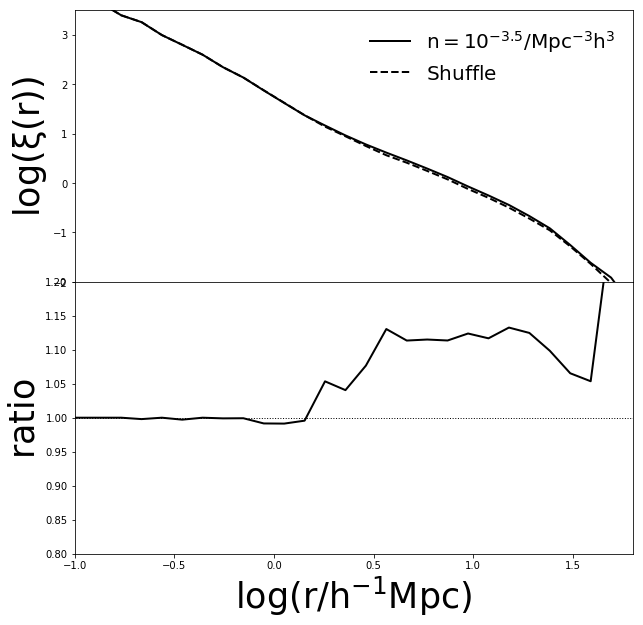

In [14]:
def plot():    
    fig,ax0 = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    gs = gridspec.GridSpec(2, 1)
    gs.update(hspace=0.0)
    ax = plt.subplot(gs[0,0])
    ax2 = plt.subplot(gs[1,0])
    colour = ['r','b','g','m','c']
    
    ax.plot( np.log10(rbins_mid), np.log10(xi_corrfunc1['xi']),color = 'k', ls= '-', linewidth = 2, label= r'$\rm n = 10^{-3.5}/Mpc^{-3}h^3$')
    ax.plot( np.log10(rbins_mid), np.log10(xi_corrfunc2['xi']),color = 'k', ls= '--', linewidth = 2, label= r'$\rm Shuffle$')
    ax2.plot(np.log10(rbins_mid), xi_corrfunc1['xi']/xi_corrfunc2['xi'],color = 'k', ls= '-', linewidth = 2 )  
    
    ax.legend(loc='best', shadow=True,fontsize=20,frameon=False)
    ax2.legend(loc='best', shadow=True,fontsize=20,frameon=False)
    ##
    ax2.plot([-3,3],[1,1],color =  'k', ls=':', linewidth=1) 
    ####################################################################################################
    ax.set_xlim([-1., 1.5])
    ax2.set_xlim([-1., 1.5])
    ax.set_ylim([-2, 3.5])
    ax2.set_ylim([0.8, 1.2])
    plt.setp(ax.get_xticklabels(), visible=False)
    ####################################################################################################
    ax.set_ylabel(r'$\rm log(\xi(r))$', fontsize=35)
    ax2.set_ylabel(r'$\rm ratio$', fontsize=35)
    ax2.set_xlabel(r'$\rm log(r/h^{-1}Mpc)$', fontsize=35)
    plt.savefig('Guo2011_z0_0p00316.pdf',rasterized=True,papertype = 'b10', bbox_inches='tight')
plot()

In [21]:
np.max(Y2)

499.99725